<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Decision Tree</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

# Подготовка

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.seasonal import seasonal_decompose

import os

In [2]:
BASE_DIR = os.getcwd()

In [3]:
df = pd.read_csv(f'{BASE_DIR}/datasets/BTC-USD(3).csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4650 entries, 0 to 4649
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    4650 non-null   object 
 1   open    4650 non-null   float64
 2   high    4650 non-null   float64
 3   low     4650 non-null   float64
 4   close   4650 non-null   float64
dtypes: float64(4), object(1)
memory usage: 181.8+ KB


In [5]:
df['time'] = pd.to_datetime(df['time'])

In [6]:
df = df.set_index(df['time']).drop('time', axis=1)
df = df.drop(['open','high','low'], axis=1)
df = df.astype('float')

In [7]:
df_d = df[['close']]

<AxesSubplot:xlabel='time'>

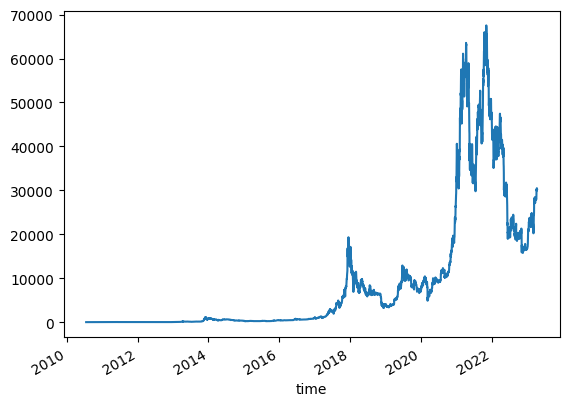

In [8]:
df_d['close'].plot(kind='line')

In [9]:
df_w = df.resample('1M').mean()

In [10]:
df_w.head()

,close
time,
2010-07-31 00:00:00+00:00,0.065631
2010-08-31 00:00:00+00:00,0.064562
2010-09-30 00:00:00+00:00,0.061851
2010-10-31 00:00:00+00:00,0.108694
2010-11-30 00:00:00+00:00,0.259286


<AxesSubplot:xlabel='time'>

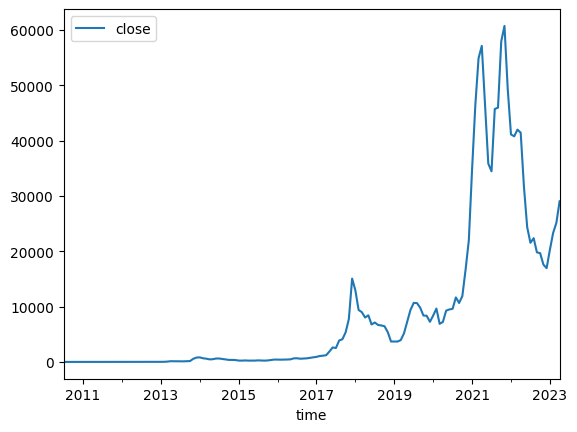

In [11]:
df_w.plot(kind='line')

## Метод Бокса-Кокса

In [12]:
from scipy import stats

In [13]:
df_wbox = df_w.copy()
df_wbox['close'], lambd = stats.boxcox(df_w['close'])

In [14]:
lambd

0.12434742963565217

In [15]:
df_wbox.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 154 entries, 2010-07-31 00:00:00+00:00 to 2023-04-30 00:00:00+00:00
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   154 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


<AxesSubplot:xlabel='time'>

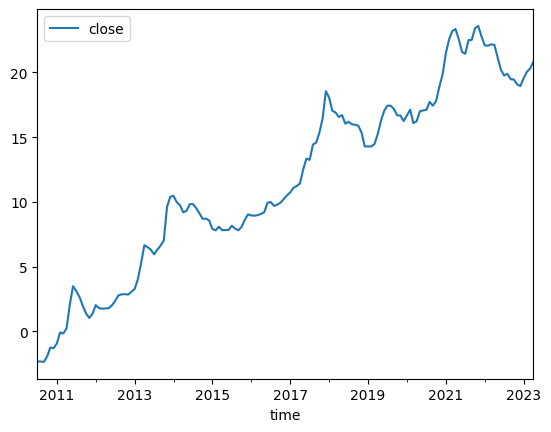

In [16]:
# df_wbox['close'] = df_wbox['close'].resample('1M').mean()
df_wbox.plot(kind='line')

## LOWESS (Locally Weighted Scatterplot Smoothing)

Отдельно ищем тренд

In [28]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [34]:
df_wbox.index.as_datatype('timestamp')

AttributeError: 'DatetimeIndex' object has no attribute 'as_datatype'

Здесь по идее нужно подобрать frac чтобы в остатке был максимальный индекс дики-фуллера

<AxesSubplot:>

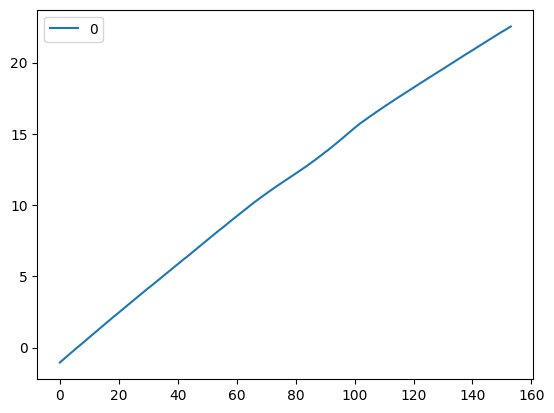

In [99]:
trend = pd.DataFrame(lowess(df_wbox['close'], df_wbox.index, frac=0.7, it=3, return_sorted=False))
trend.plot(kind='line')

<AxesSubplot:xlabel='time'>

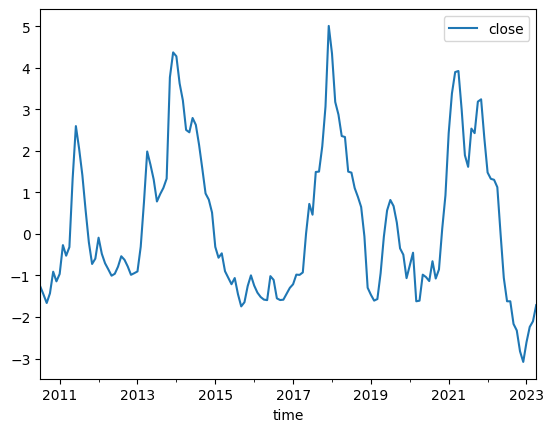

In [100]:
trend.set_index(df_wbox.index, inplace=True)
df_wbox_t = df_wbox.copy()
df_wbox_t['close'] = (df_wbox['close'] - trend[0])
df_wbox_t.plot(kind='line')


In [108]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_wbox_t)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -4.082853896991463
p-value: 0.0010336955669430247
Critical Values: {'1%': -3.4759527332353084, '5%': -2.881548071241103, '10%': -2.577438765246763}


## Автокорреляция

<AxesSubplot:xlabel='time'>

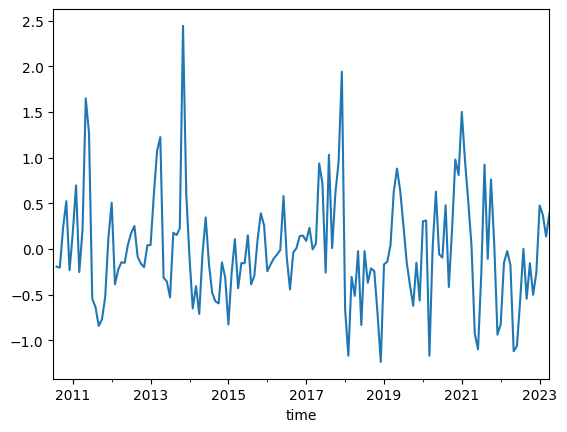

In [101]:
(df_wbox_t['close'] - df_wbox_t['close'].shift(1)).plot(kind='line')

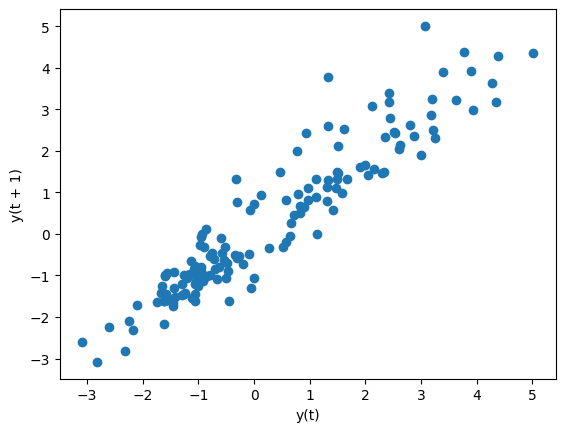

In [107]:
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
lag_plot(df_wbox_t['close'])
pyplot.show()

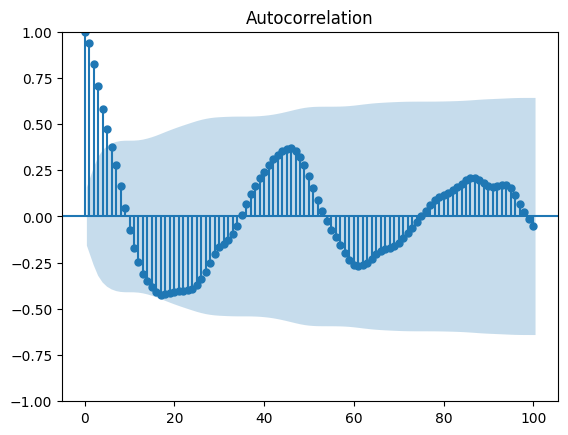

In [110]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_wbox_t['close'], lags=100)
pyplot.show()

## Вычленение сезонности с плавающим периодом

Для определения пиков можно использовать пересечение 111MA и 350MA

<AxesSubplot:xlabel='time'>

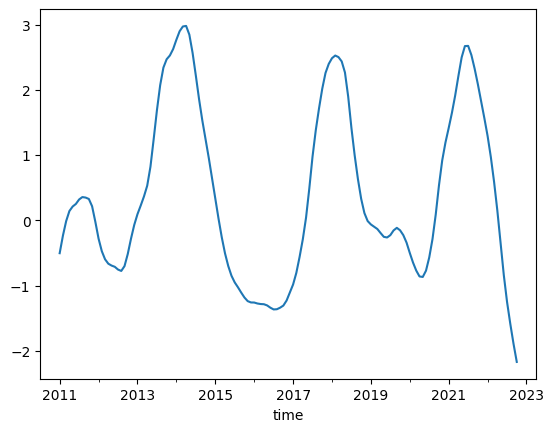

In [89]:
decomposed = seasonal_decompose(df_wbox_t['close'])
decomposed.trend.plot()

<AxesSubplot:xlabel='time'>

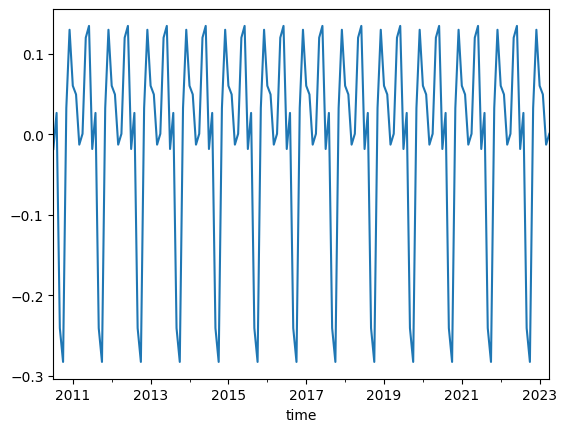

In [90]:
decomposed.seasonal.plot()

<AxesSubplot:xlabel='time'>

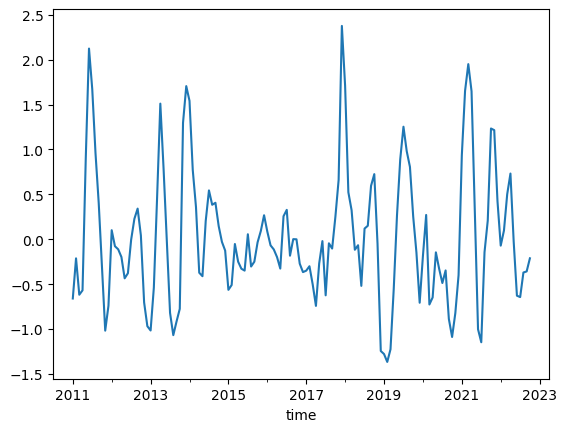

In [91]:
decomposed.resid.plot()

Кореллограмма
Найти циклы (переменная сезонность)
Выровнить график, логарифмическая шкала + логарифмическая кривая, мб квадратичная функция
Логарифмирование-частный случай бокс-кокса стабилизация дисперсии 
Дифференцирование yt - y(t-1)

In [22]:
# decomposed = seasonal_decompose(df_d['2018-04-01':'2018-10-1'])
# decomposed.trend.plot()
# decomposed.seasonal.plot()
# decomposed.resid.plot()

In [23]:
df_wn = (df_w - df_w.shift())

<AxesSubplot:xlabel='time'>

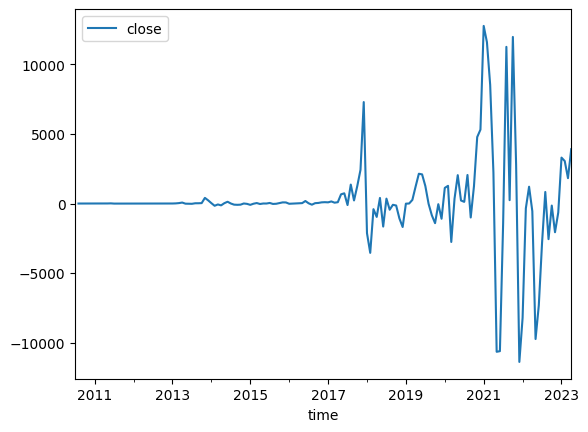

In [24]:
df_wn.plot(kind='line')